In [1]:
import os

import cv2

import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from logwriter import Logger

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ]))

mnist_dataloader = DataLoader(mnist_trainset, shuffle=True, batch_size=64)
dataloader_size = len(mnist_dataloader)

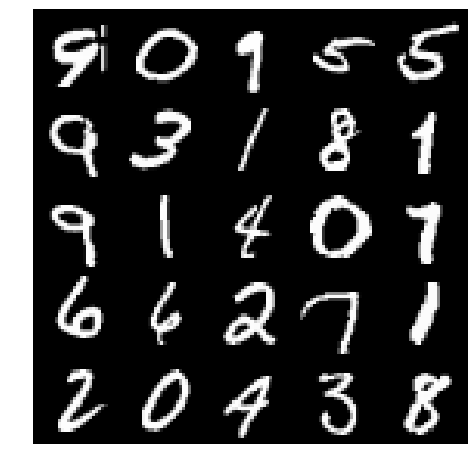

In [4]:
def show_images(images, n_images, nrow=5):
    plt.figure(figsize=(15, 8))
    plt.imshow(torchvision.utils.make_grid(images.data[:n_images], 
                                           normalize=True, 
                                           scale_each=True, 
                                           padding=0, 
                                           nrow=nrow).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    
images, _ = next(iter(mnist_dataloader))
show_images(images, 25)

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(VAE, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.encoder_fc1 = nn.Sequential(
                nn.Linear(self.input_size * self.input_size, 256),
                nn.BatchNorm1d(256),
                nn.ReLU()
            )
        
        self.encoder_fc2 = nn.Sequential(
                nn.Linear(256, 512),
                nn.BatchNorm1d(512),
                nn.ReLU()
            )
        
        self.encoder_fc3 = nn.Sequential(
                nn.Linear(512, self.hidden_size),
                nn.BatchNorm1d(self.hidden_size),
                nn.ReLU()
            )
        
        self.decoder_fc1 = nn.Sequential(
                nn.Linear(self.hidden_size, 512),
                nn.BatchNorm1d(512),
                nn.ReLU()
            )
        
        self.decoder_fc2 = nn.Sequential(
                nn.Linear(512, 256),
                nn.BatchNorm1d(256),
                nn.ReLU()
            )

        self.decoder_fc3 = nn.Sequential(
            nn.Linear(256, self.input_size * self.input_size),
            nn.BatchNorm1d(self.input_size * self.input_size),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(-1, self.input_size * self.input_size)
        x = self.encoder_fc1(x)
        x = self.encoder_fc2(x)
        x = self.encoder_fc3(x)
        
        mean = x.mean(1).view(-1, 1)
        std = x.std(1).view(-1, 1)

        epsilon = torch.randn(x.shape, device=device)
        x = mean + epsilon * std
        
        x = self.decoder_fc1(x)
        x = self.decoder_fc2(x)        
        x = self.decoder_fc3(x)
        
        x = x.view(-1, 1, self.input_size, self.input_size)
        return mean, std, x

In [ ]:
ReconstructionLoss = torch.nn.MSELoss()

def KLDivergence(mean, std):
    return -0.5 * torch.sum(1 + 2 * torch.log(std) - mean**2 - std**2)

In [ ]:
n_epochs = 100
learning_rate = 1e-4

vae = VAE(28, 100).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

logger = Logger(f'vae_mnist_epoch{n_epochs}_lr{learning_rate}', 'First test')
logger.get_run_command()

'tensorboard --logdir=C:\\Users\\Jonathan\\Documents\\development\\gan/runs/vae_mnist_epoch100_lr0.0001/Nov-15-2018-12h27m45s/ --host=127.0.0.1'

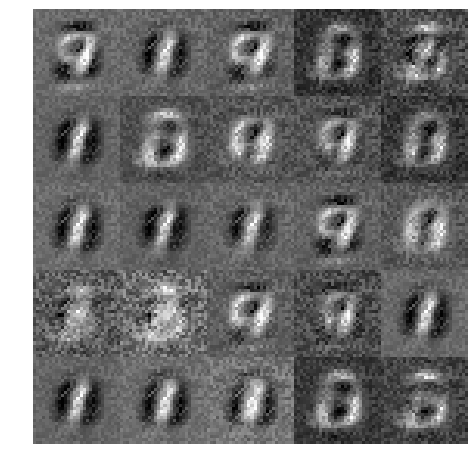

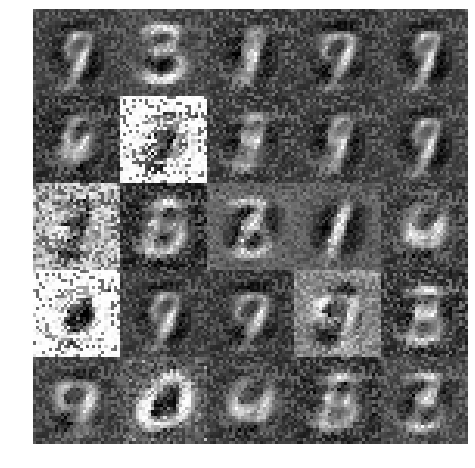

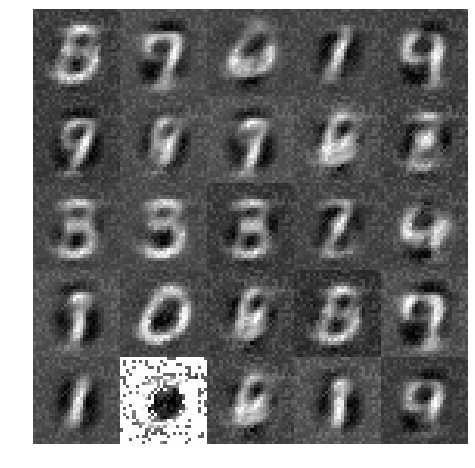

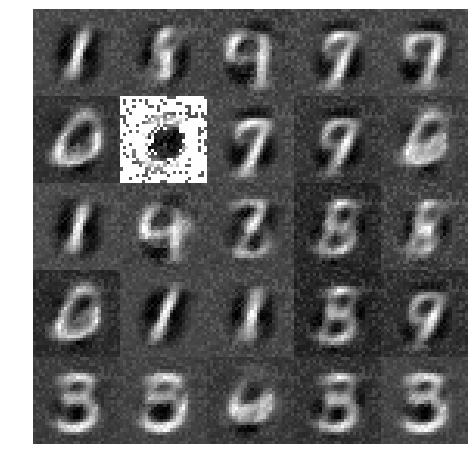

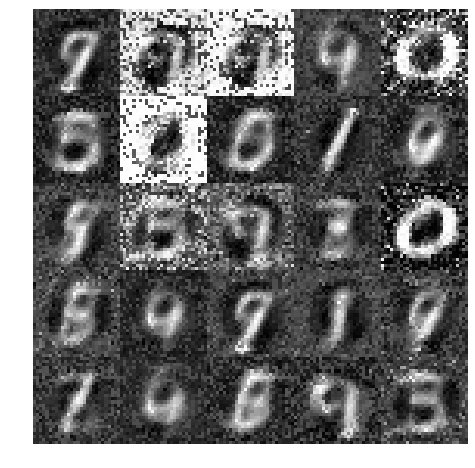

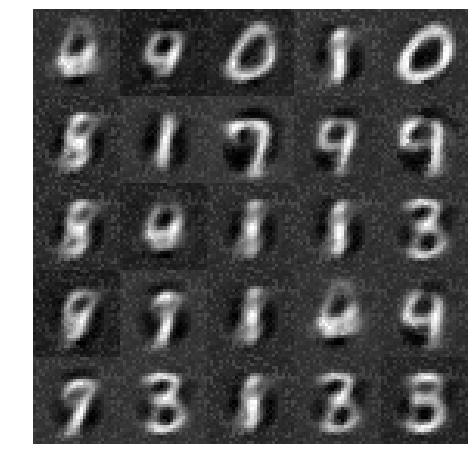

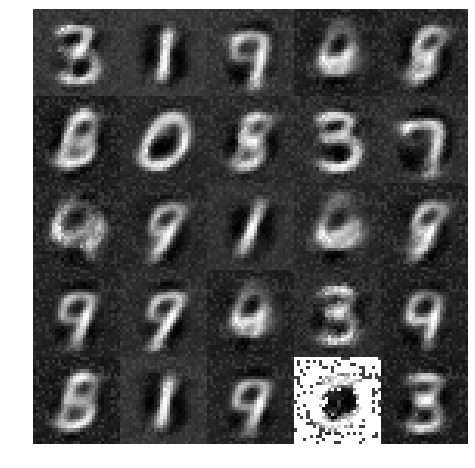

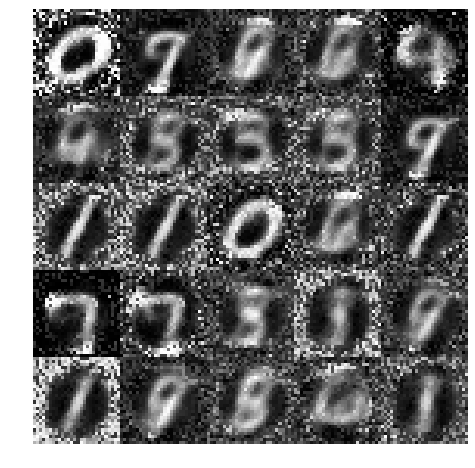

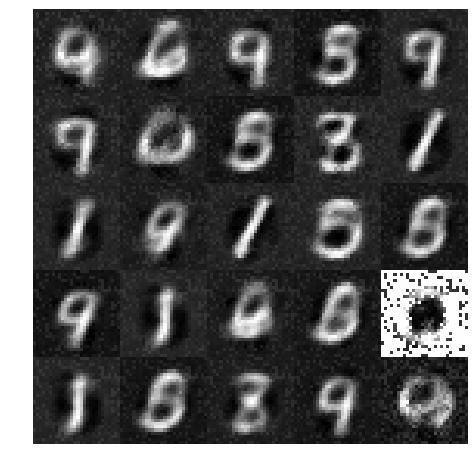

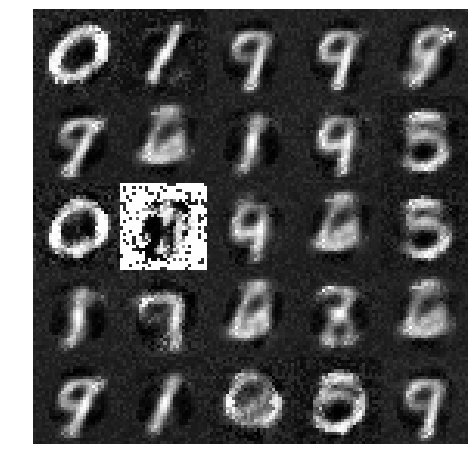

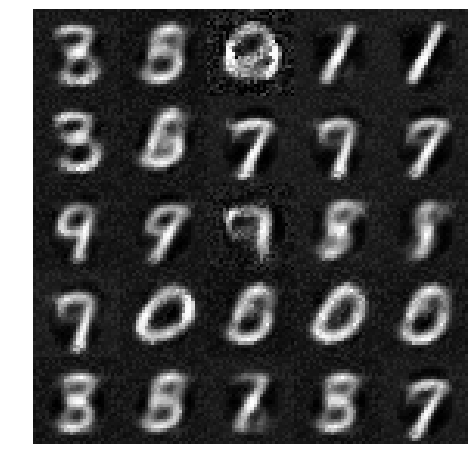

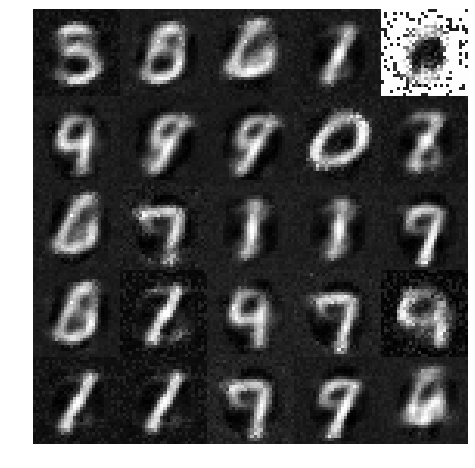

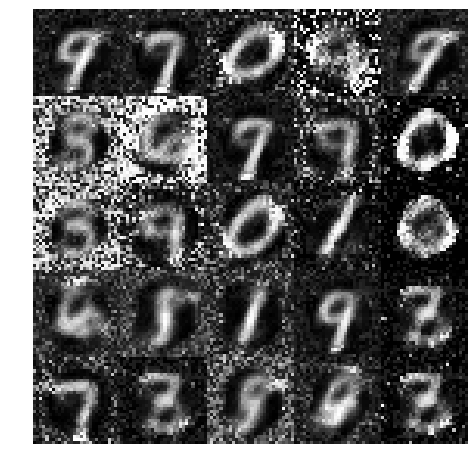

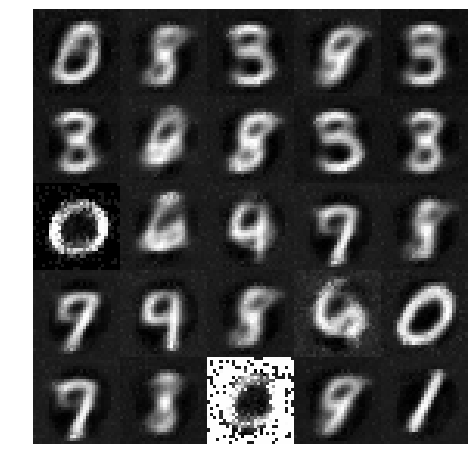

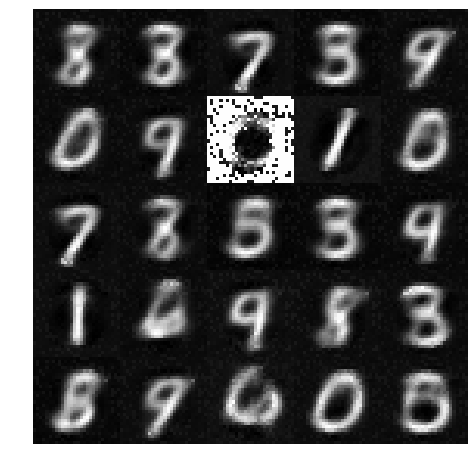

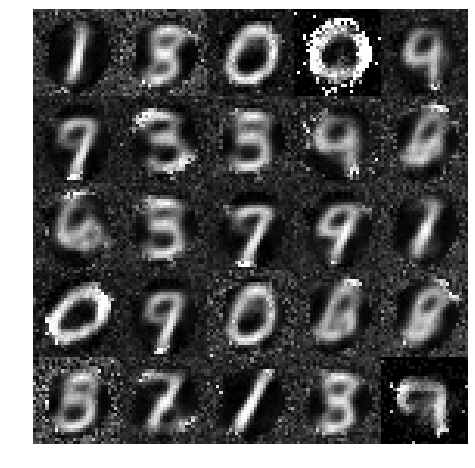

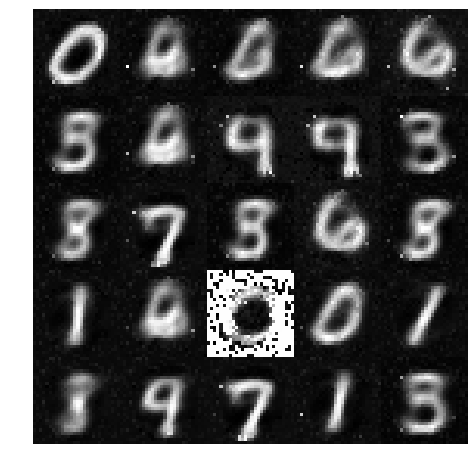

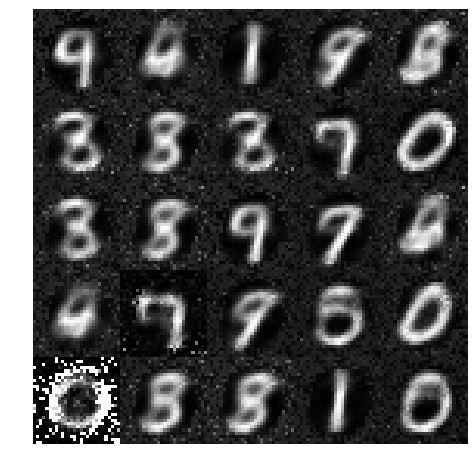

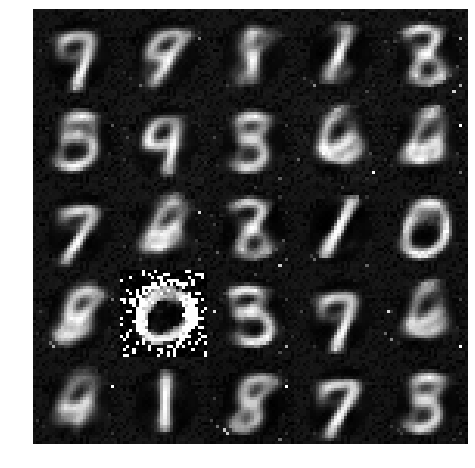

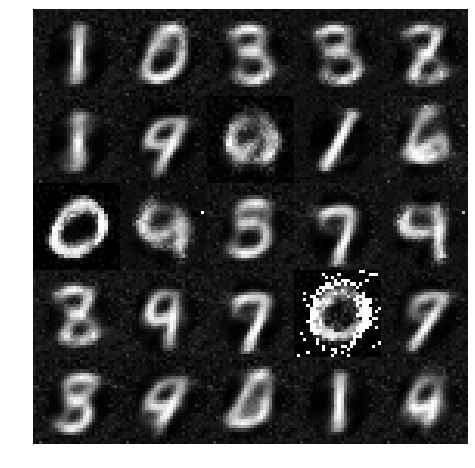

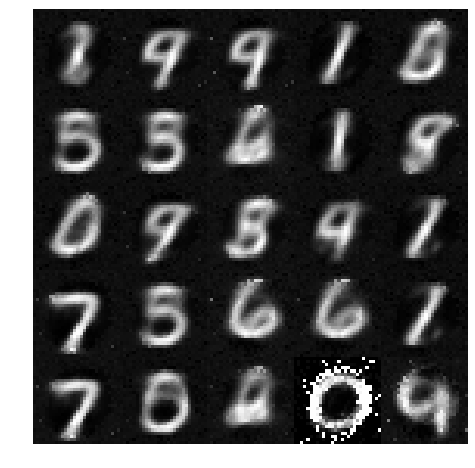

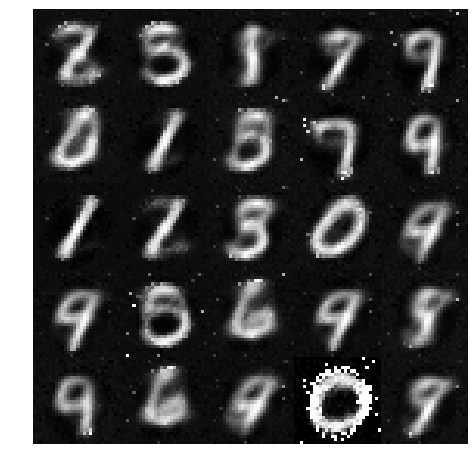

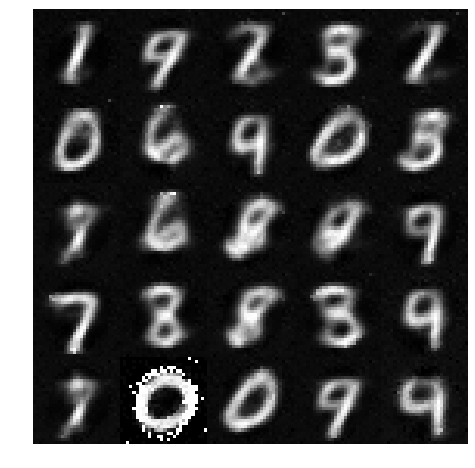

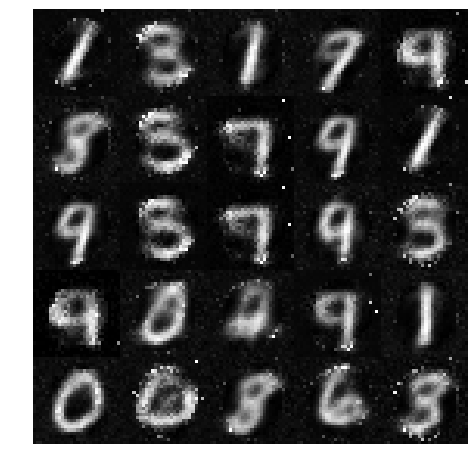

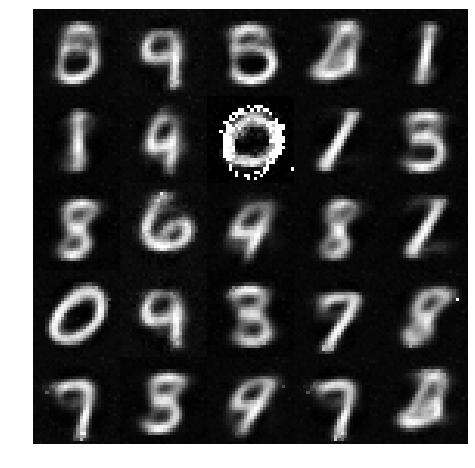

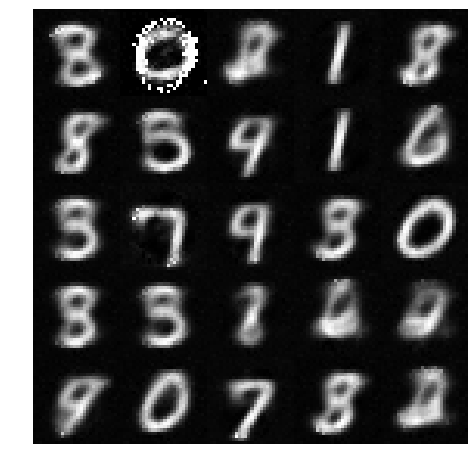

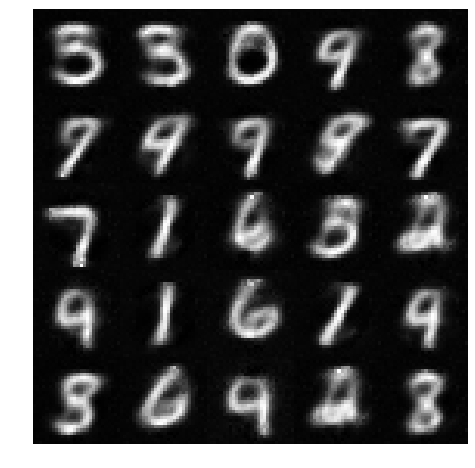

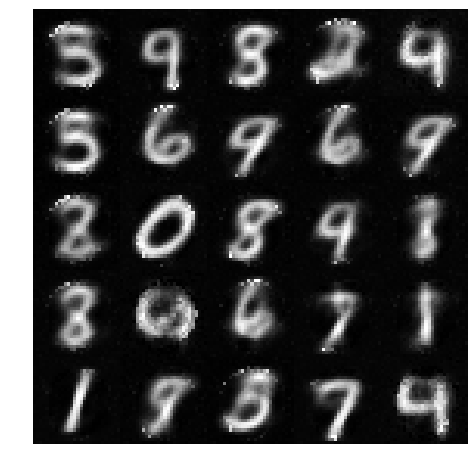

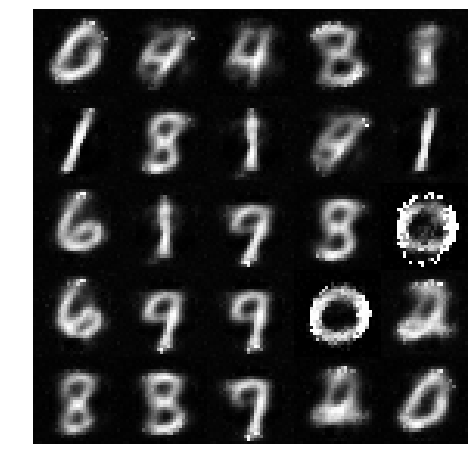

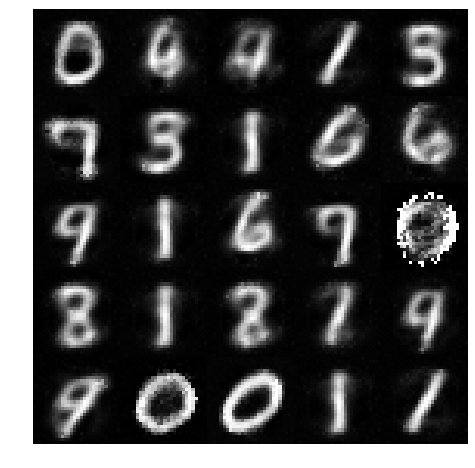

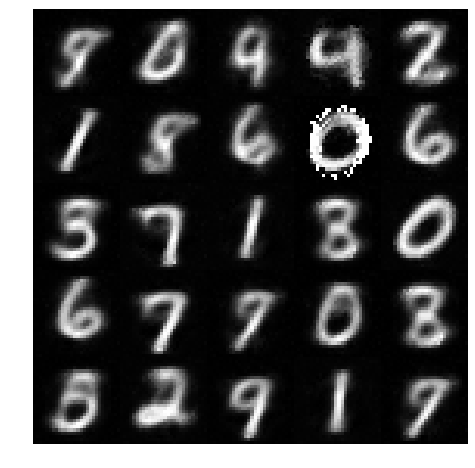

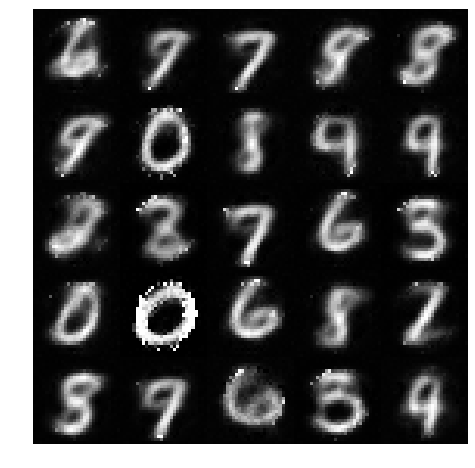

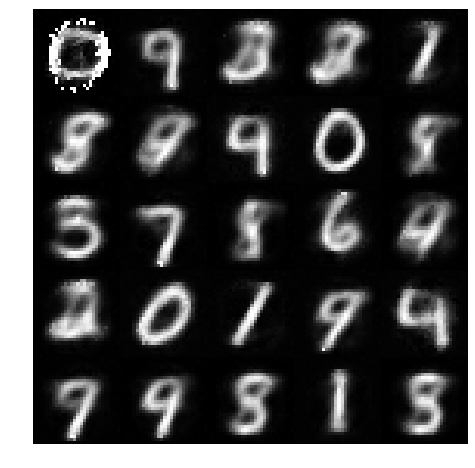

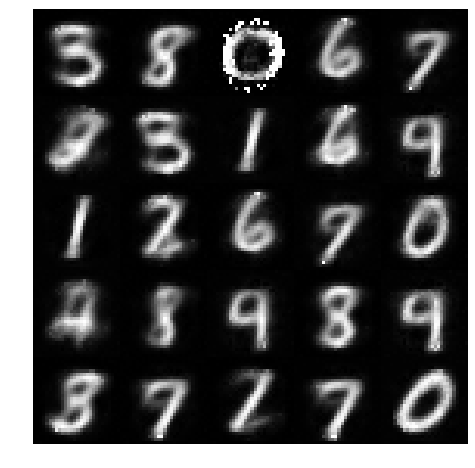

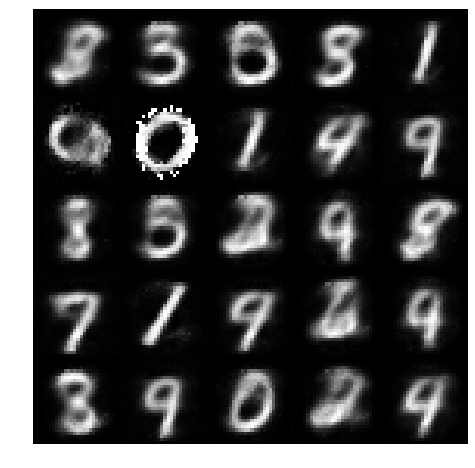

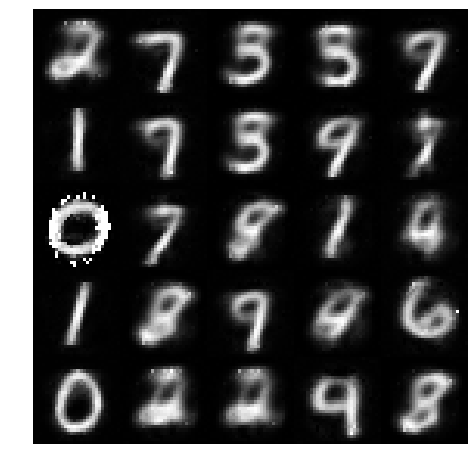

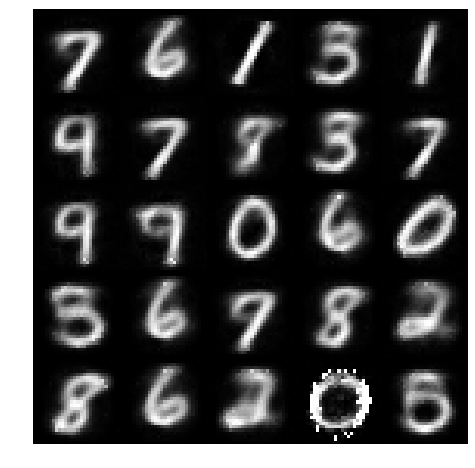

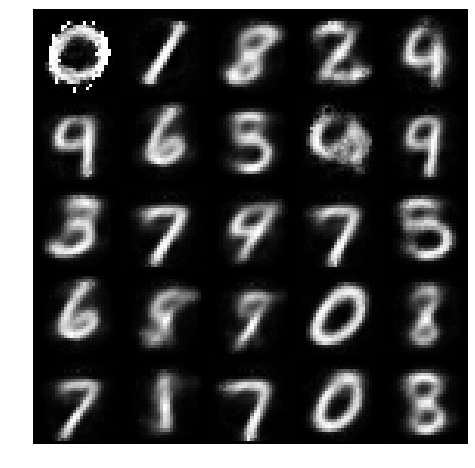

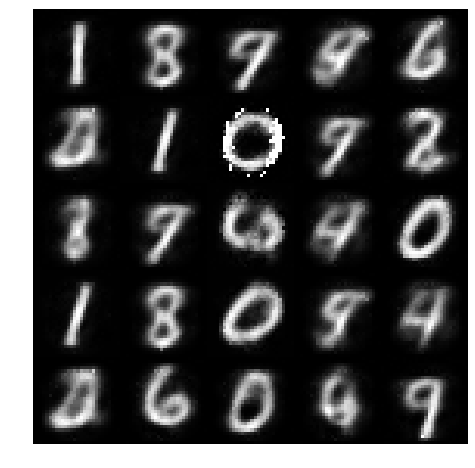

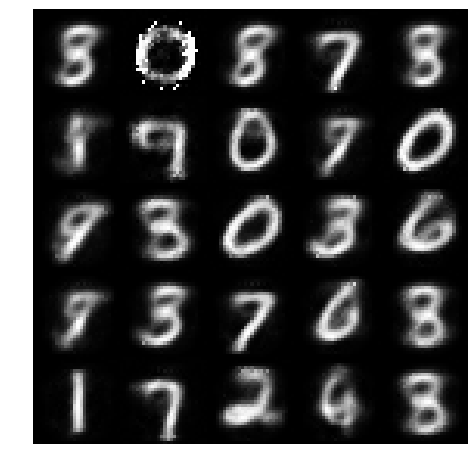

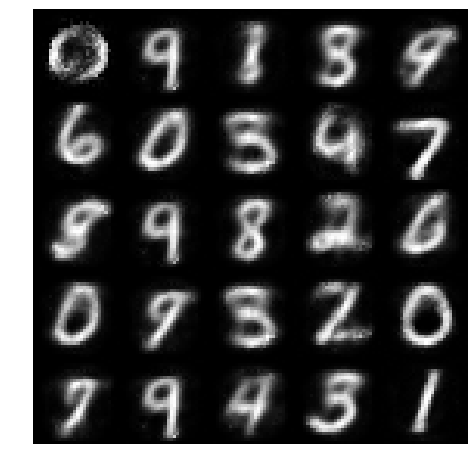

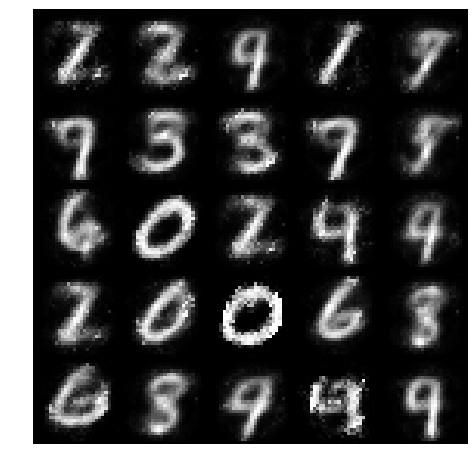

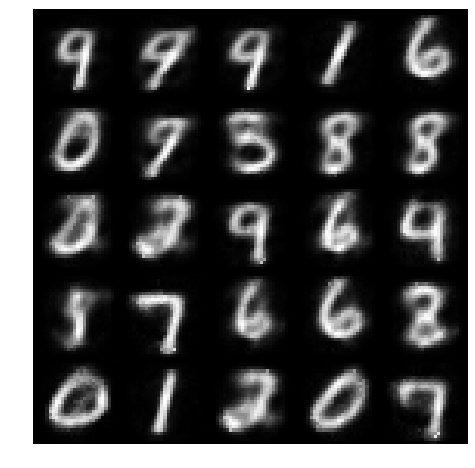

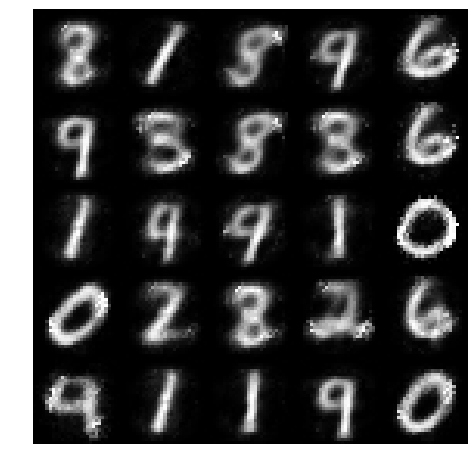

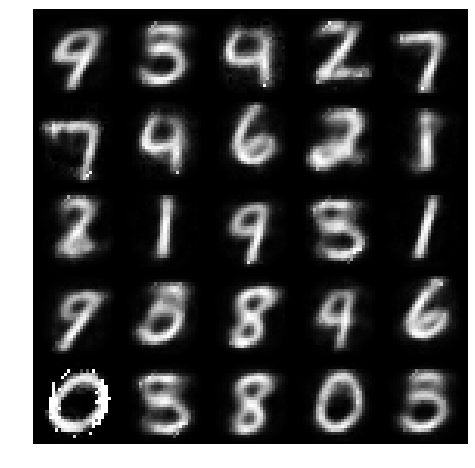

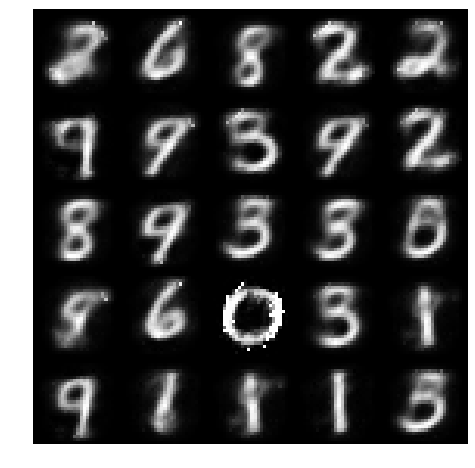

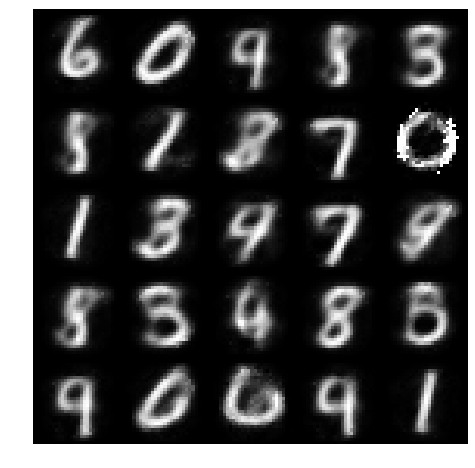

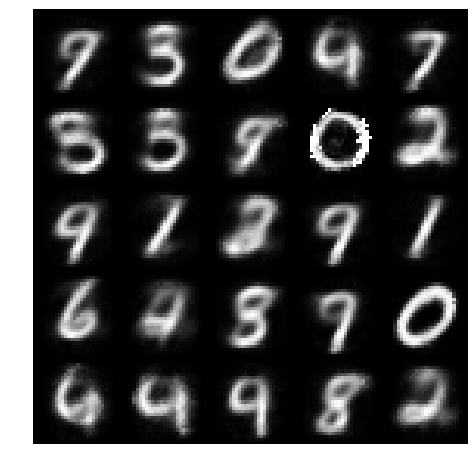

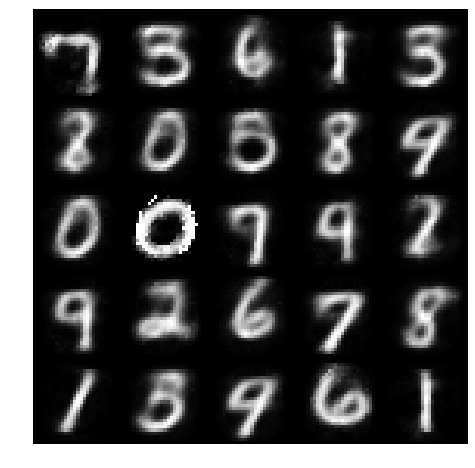

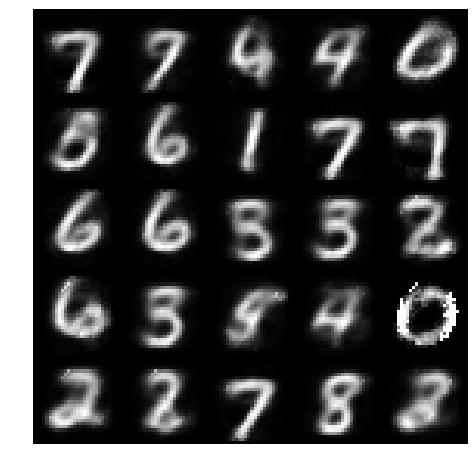

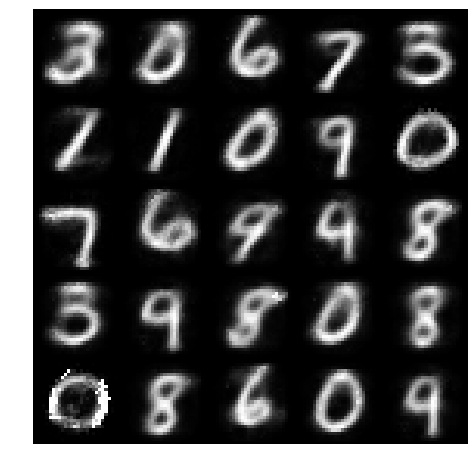

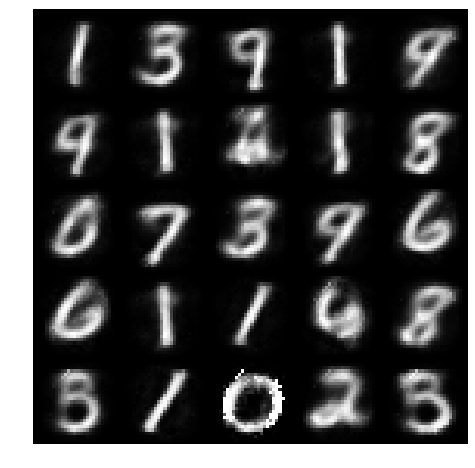

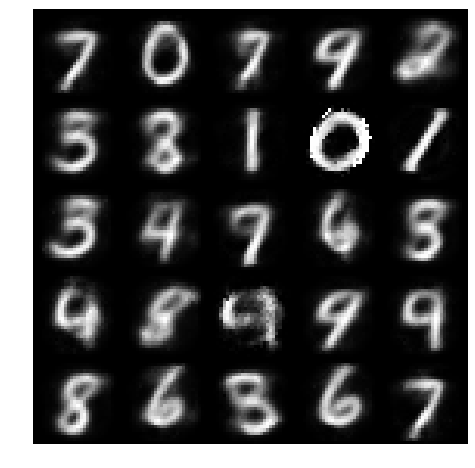

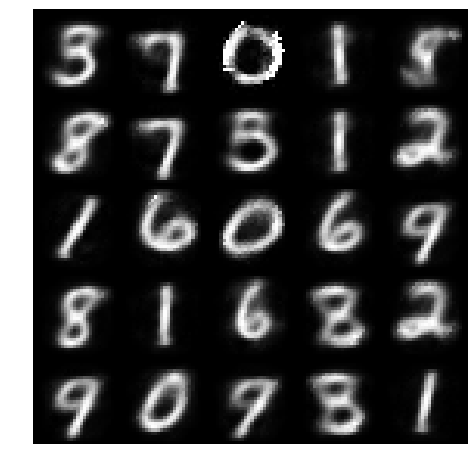

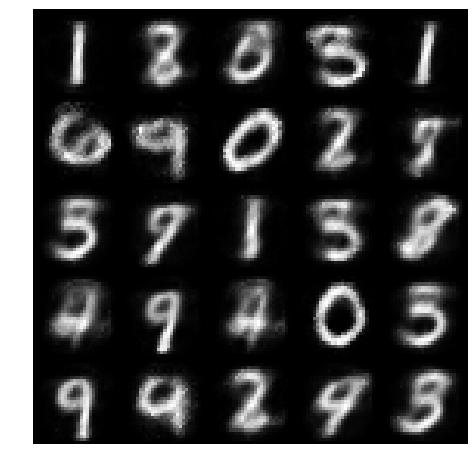

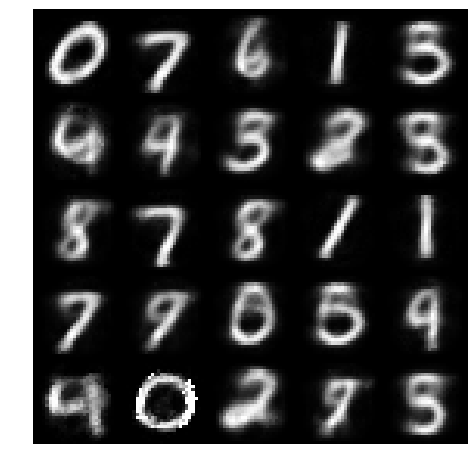

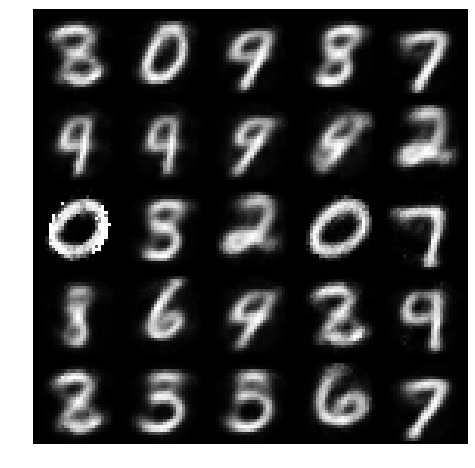

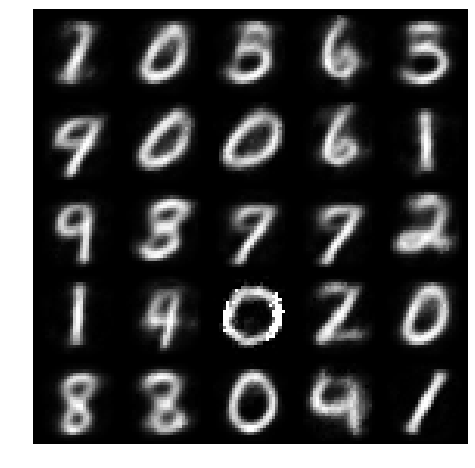

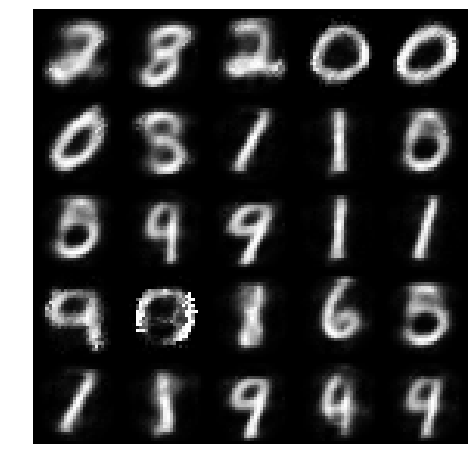

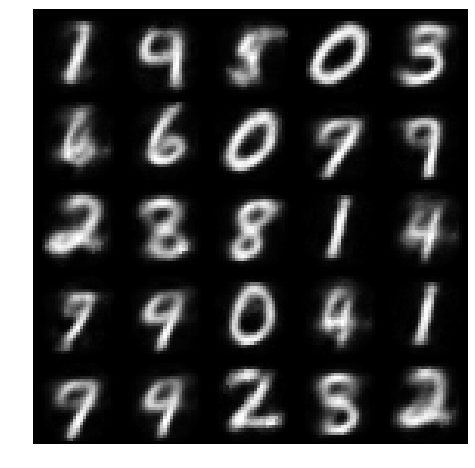

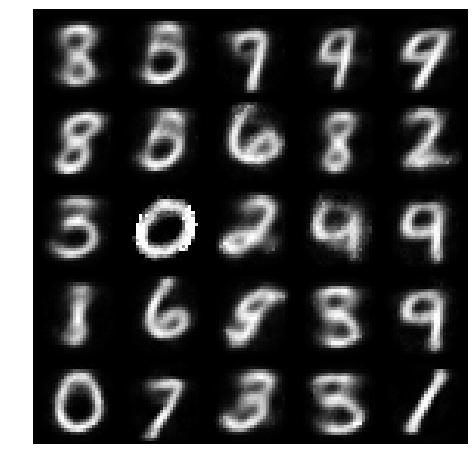

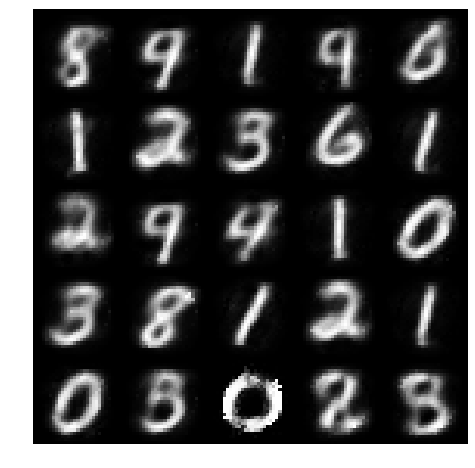

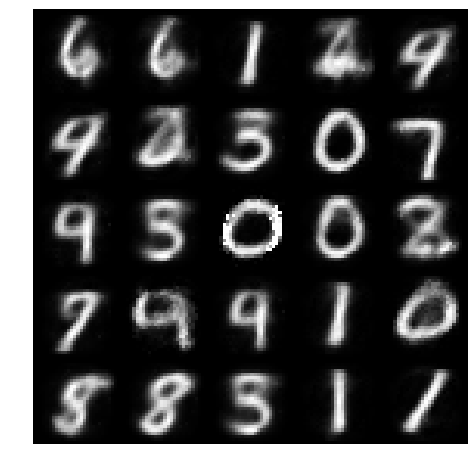

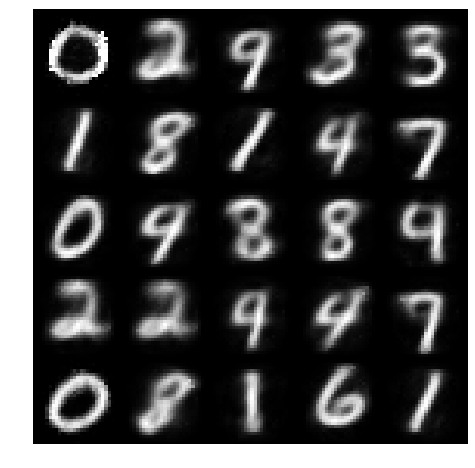

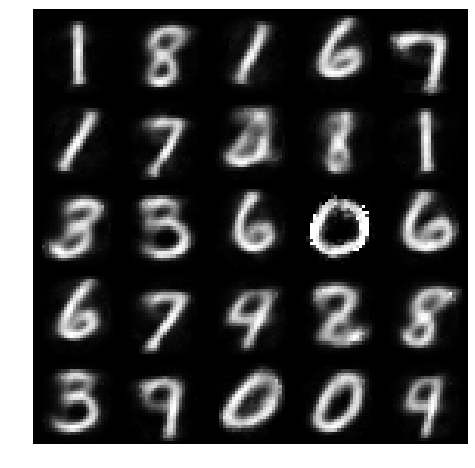

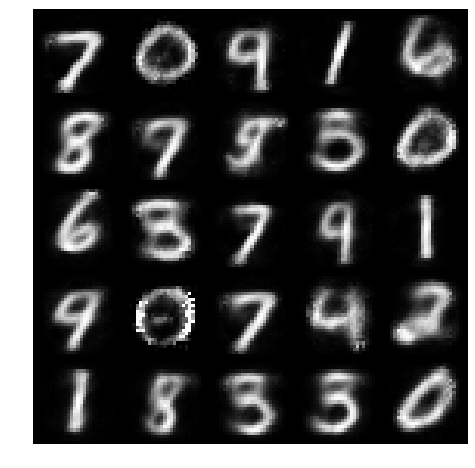

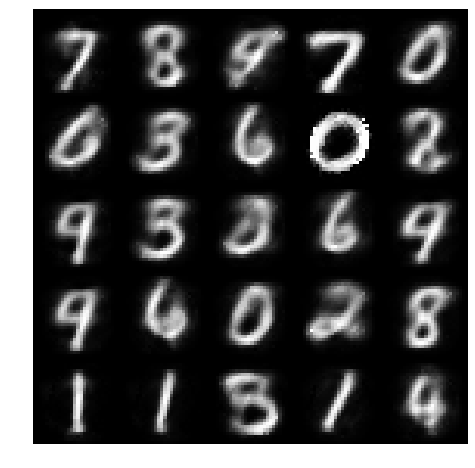

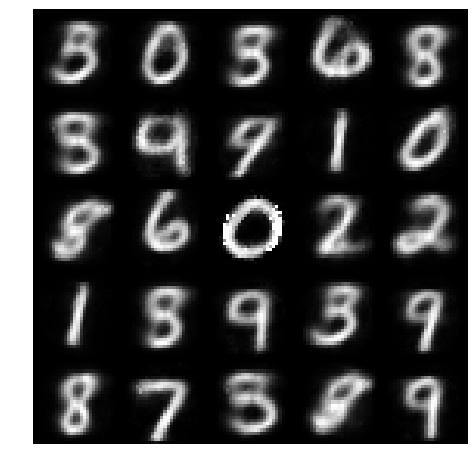

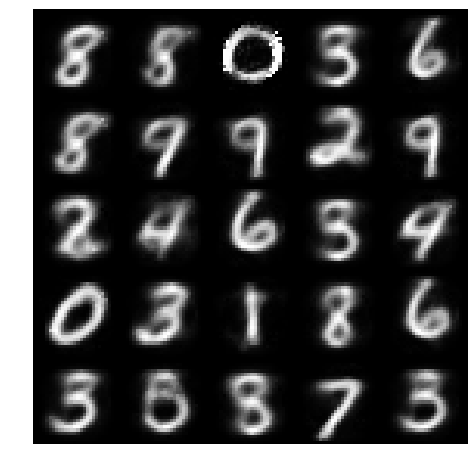

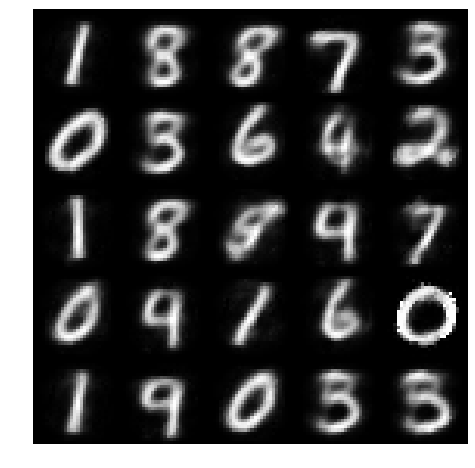

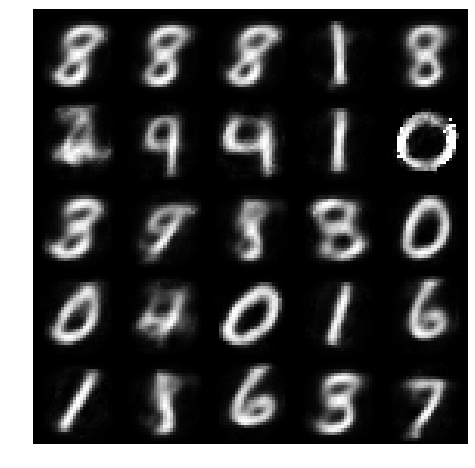

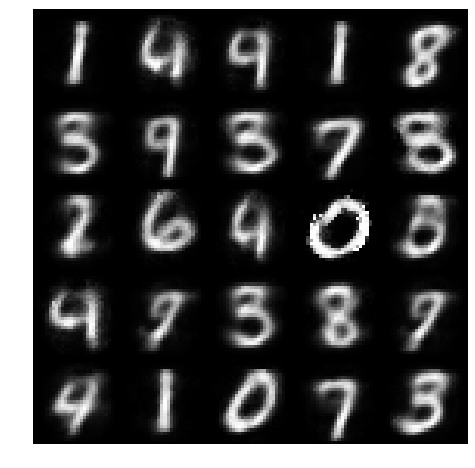

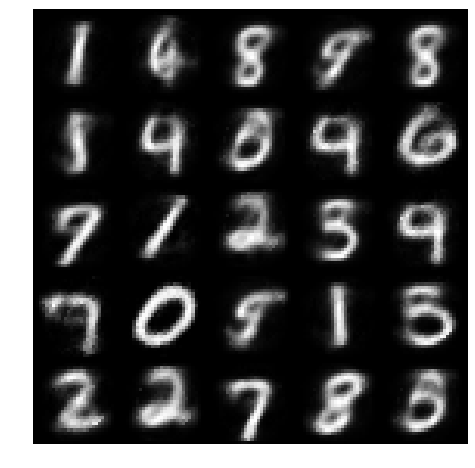

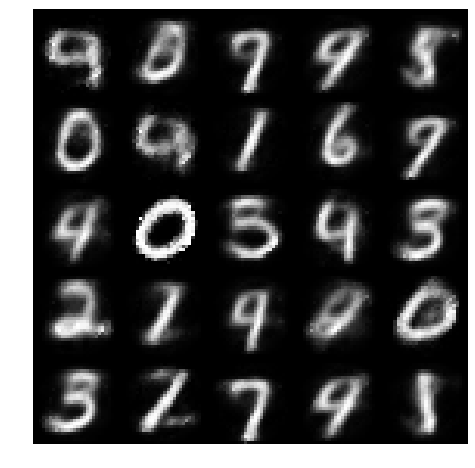

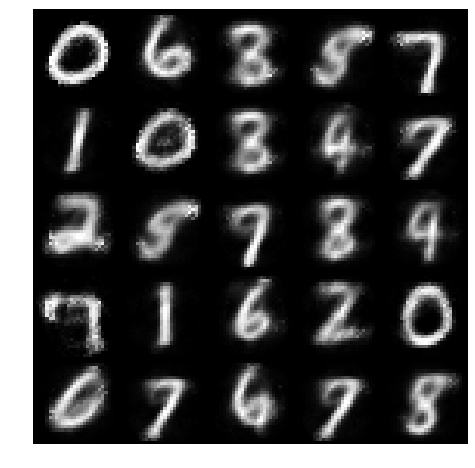

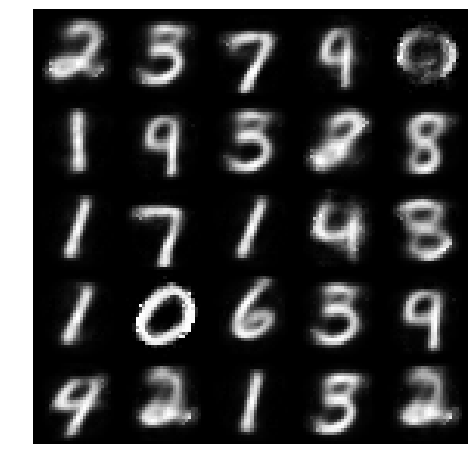

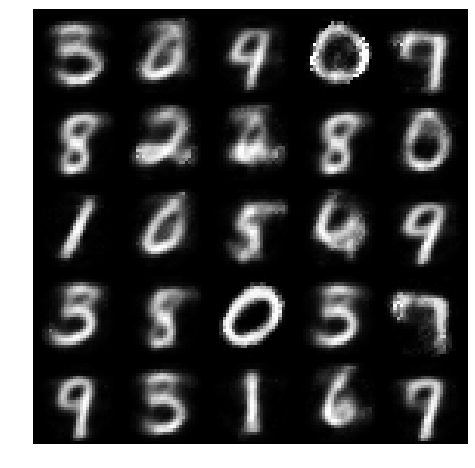

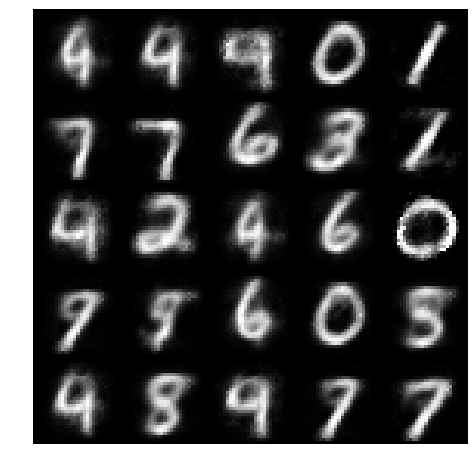

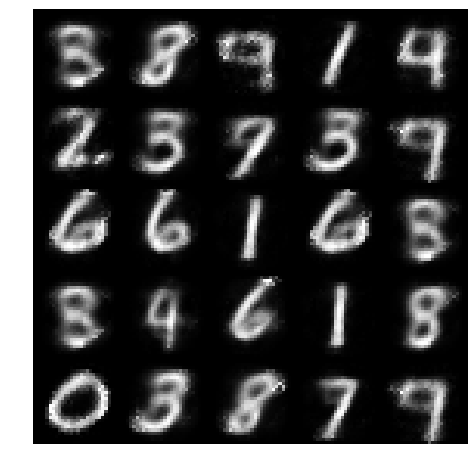

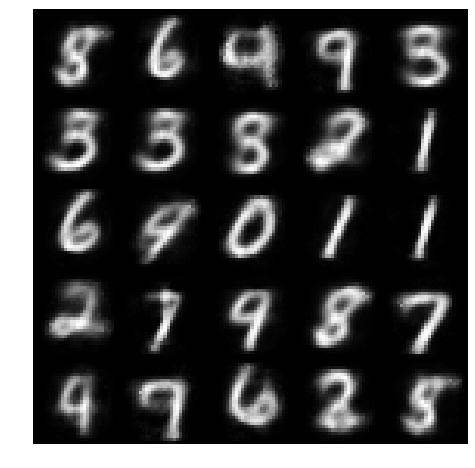

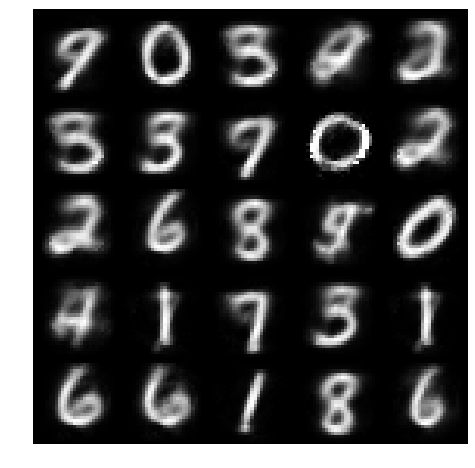

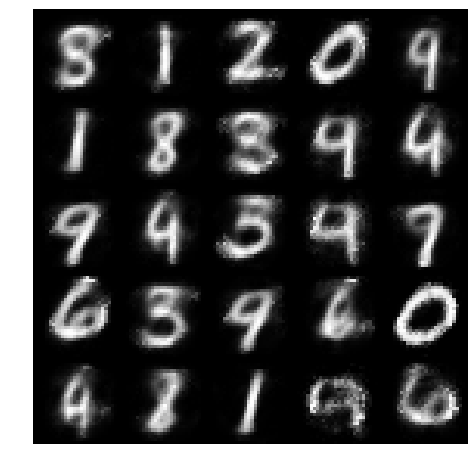

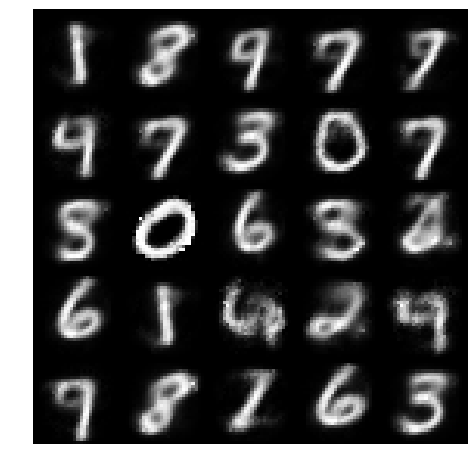

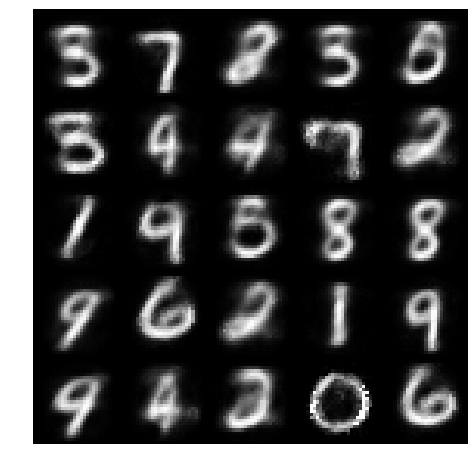

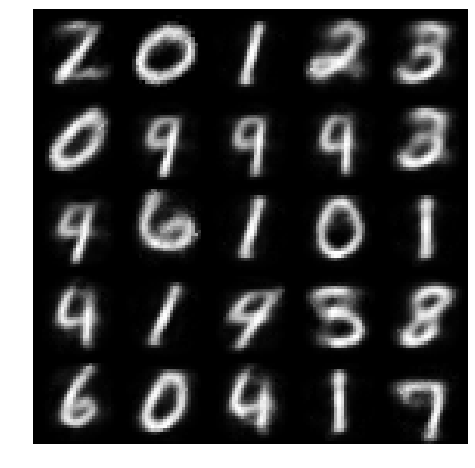

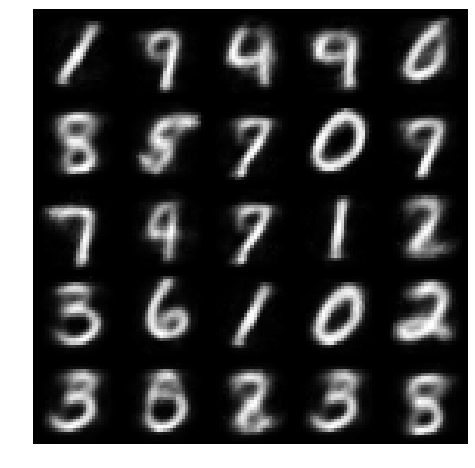

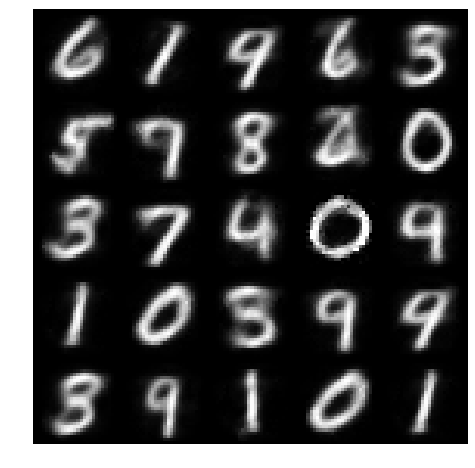

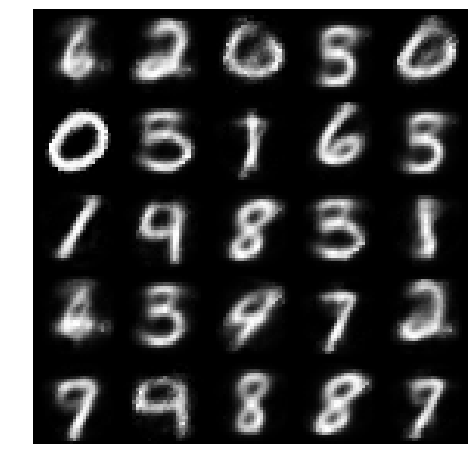

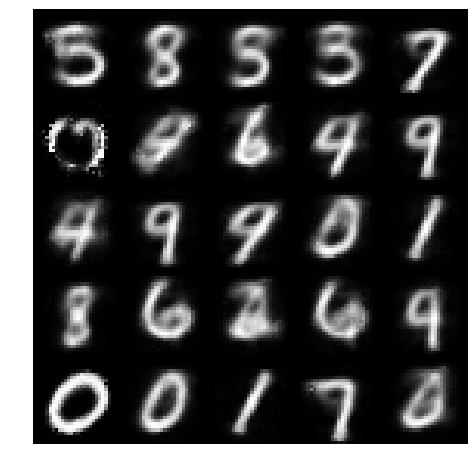

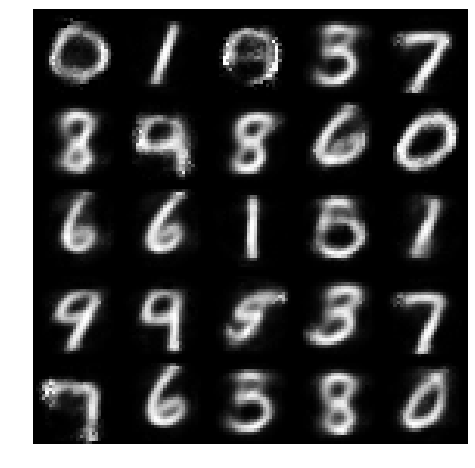

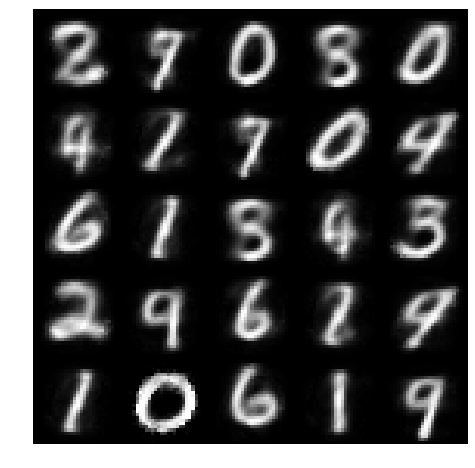

In [ ]:
for epoch in range(n_epochs):
    for images, _ in mnist_dataloader:
        images = images.to(device)
        mean, std, output = vae(images)

        optimizer.zero_grad()
        reconstruction_loss = ReconstructionLoss(images, output)
        kl_divergence = KLDivergence(mean, std)
        vae_loss = reconstruction_loss + kl_divergence
        vae_loss.backward()
        optimizer.step()

        
        logger.log(reconstruction_loss, 'reconstruction_loss')
        logger.log(kl_divergence, 'kl_divergence')
        logger.log(vae_loss, 'vae_loss')
        if logger.get_step() % 2000 == 0:
            logger.log_image(output, 'output_images')

        logger.step()

    show_images(output, 25)